# Binary Classification

Source: https://github.com/logictensornetworks/logictensornetworks/blob/master/examples/binary_classification/binary_classification.ipynb

Modified by Erik Mayer:
+ 6/17/2024: To work on Google Colab, added !pip install...
+ 6/20/2024: See below (undone on 6/23/2024?)
+ 6/21/2024: Specifying array values
+ 6/23/2024: Using data from eflux file on GitHub.
++ 7:52 am: Switched to eflux file for 3/18/2024 2:00 UT with more interesting data, but training appears to have issues. Taking long time and sat level is nan. Number of data points too large?
+ 6/24/2024: Experimenting with training
++ 7:15 am: Tried shuffling dataset, but seemed to only get 100 data points. Pulls 100 data points and then shuffles? See below.
++ 7:45 pm: Trying to shuffle numpy array array_eflux
+ 6/27/2024: Branching from binary_classification_2024_0624_p0743.ipynb
++ Attempting to choose a different set of training data every epoch (see comment in code below)


This is a basic example in which we learn to ground unary predicate $A$ that is defined in the space of $[0,1]^2$.

We define the predicate $A$ to apply to points that are close to the middle point $c=(.5,.5)$.In order to get training data, we randomly sample data from the domain. We split the sample data into two separate sets based on their euclidian distance to $c$. We then define two facts for the predicate $A$. For all points the predicate should apply to, we provide them as positive examples and vice versa for all points that the predicate does not apply to.

To add a local copy of the LogicTensorNetworks repository into your Colab environment, use the following command:

In [1]:
!pip install git+https://github.com/logictensornetworks/logictensornetworks

  Cloning https://github.com/logictensornetworks/logictensornetworks to /tmp/pip-req-build-xe9yr21b
  Running command git clone --filter=blob:none --quiet https://github.com/logictensornetworks/logictensornetworks /tmp/pip-req-build-xe9yr21b
  Resolved https://github.com/logictensornetworks/logictensornetworks to commit d62d101f90be8ec029de90cb1db5df01c2c58d72
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ltn: filename=ltn-2.1-py3-none-any.whl size=13027 sha256=b61e561291b0d382c0438b9c9ca80992ee6f9606ca959e5de0c9902443704622
  Stored in directory: /tmp/pip-ephem-wheel-cache-stbruir5/wheels/85/92/5c/138f4ade7bf608ca2b334e77af7af507a4e60bcb33b088f529
Successfully built ltn


In [2]:
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import ltn

plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1

Sample random data from $[0,1]^2$. Our groundtruth positive training data for $A$ is close to the center (.5,.5). All other data is considered as negative examples.

# E.M. modifications 6/23/2024

Read data from IMF file on GitHub (see File_reading_2024_0623_a0607.ipynb)

In [3]:
import pandas as pd

import numpy as np

In [ ]:
# input data
# 6/23/2024 Not currently using this data in this notebook

df_IMF = pd.read_csv(r"https://raw.githubusercontent.com/ErikMayerPSU/AuroraNSL_2024/main/data/St%20patrick's%20day%202015/20150317_IMF.txt", header=None, nrows=1, delim_whitespace=True, on_bad_lines='skip')

# Define new headers
IMF_headers = ["Year", "Month", "Day", "Hour", "Min", "Sec", "Msec", "Bx[nT]", "By[nT]", "Bz[nT]", "Vx[km/s]", "Vy[km/s]", "Vz[km/s]", "N[cm^(-3)]", "T[Kelvin]"]

# Set the column headers
df_IMF.columns = IMF_headers

df_IMF

,Year,Month,Day,Hour,Min,Sec,Msec,Bx[nT],By[nT],Bz[nT],Vx[km/s],Vy[km/s],Vz[km/s],N[cm^(-3)],T[Kelvin]
0,2015,3,17,0,0,0,0,-4.41,-0.319,6.176,-422.716,13.163,-5.809,12.914,43258.2


In [4]:
# output data

df_eflux = pd.read_csv(r"https://raw.githubusercontent.com/ErikMayerPSU/AuroraNSL_2024/main/data/St%20patrick's%20day%202015/Eflux/20150318_0200UT_Eflux_e%2Call.txt", header=None, skiprows=1, nrows=7680, delim_whitespace=True, on_bad_lines='skip')

# Define new headers
eflux_headers = ["MLT", "ML", "[mW m^-2]"]

# Set the column headers
df_eflux.columns = eflux_headers

df_eflux

,MLT,ML,[mW m^-2]
0,0.00,50.0,0.009205
1,0.00,50.5,0.009303
2,0.00,51.0,0.005775
3,0.00,51.5,0.020590
4,0.00,52.0,0.000387
...,...,...,...
7675,23.75,87.5,0.023140
7676,23.75,88.0,0.022190
7677,23.75,88.5,0.023080
7678,23.75,89.0,0.016270


In [5]:
array_eflux = df_eflux.to_numpy()
array_eflux

array([[0.000e+00, 5.000e+01, 9.205e-03],
       [0.000e+00, 5.050e+01, 9.303e-03],
       [0.000e+00, 5.100e+01, 5.775e-03],
       ...,
       [2.375e+01, 8.850e+01, 2.308e-02],
       [2.375e+01, 8.900e+01, 1.627e-02],
       [2.375e+01, 8.950e+01, 2.794e-02]])

In [6]:
# 6/24/2024 7:45 pm Trying to shuffle numpy array array_eflux
np.random.shuffle(array_eflux)
array_eflux

array([[8.750e+00, 6.750e+01, 2.258e+00],
       [1.000e+00, 6.950e+01, 2.704e+00],
       [1.850e+01, 6.550e+01, 1.562e+00],
       ...,
       [1.550e+01, 8.150e+01, 1.300e-02],
       [1.725e+01, 5.700e+01, 1.686e-02],
       [1.175e+01, 6.300e+01, 1.560e-01]])

In [7]:
array_eflux_mag_coordinates = array_eflux[0:7680,0:2]
array_eflux_mag_coordinates
data = array_eflux_mag_coordinates
data

array([[ 8.75, 67.5 ],
       [ 1.  , 69.5 ],
       [18.5 , 65.5 ],
       ...,
       [15.5 , 81.5 ],
       [17.25, 57.  ],
       [11.75, 63.  ]])

In [8]:
array_eflux_flux = array_eflux[0:7680,2:3]
print(array_eflux_flux)
# Flatten to 1-D array
array_eflux_flux_flatten = array_eflux_flux.flatten(order = 'C')
print(array_eflux_flux_flatten)


[[2.258  ]
 [2.704  ]
 [1.562  ]
 ...
 [0.013  ]
 [0.01686]
 [0.156  ]]
[2.258   2.704   1.562   ... 0.013   0.01686 0.156  ]


In [9]:
# Using aurora visibility threshold = 1
labels = array_eflux_flux_flatten > 1.0
# labels_b = np.sum(np.square(data_b-[.5,.5]),axis=1)<.16
print(labels)

[ True  True  True ... False False False]


Data for A:
[[ 8.75 67.5 ]
 [ 1.   69.5 ]
 [18.5  65.5 ]
 ...
 [15.5  81.5 ]
 [17.25 57.  ]
 [11.75 63.  ]]
[ True  True  True ... False False False]


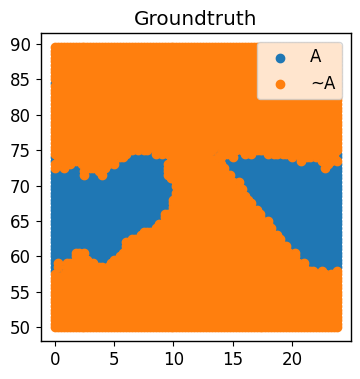

Data for B:
[[0.55 0.55]
 [0.65 0.65]
 [0.45 0.45]
 [0.35 0.35]
 [0.25 0.25]
 [0.15 0.15]]
[ True  True  True  True  True False]


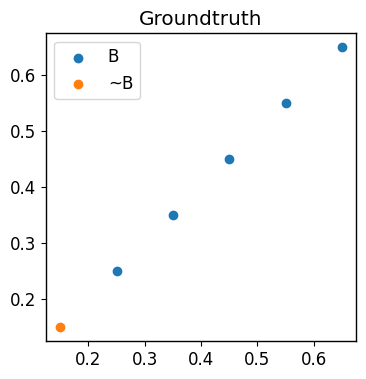

Plotting A and B on same graph


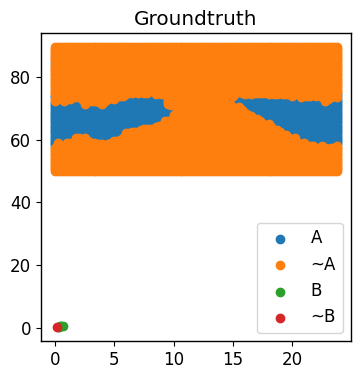

Concatendated A and B data (6/23/2024: just using A):
[[ 8.75 67.5 ]
 [ 1.   69.5 ]
 [18.5  65.5 ]
 ...
 [15.5  81.5 ]
 [17.25 57.  ]
 [11.75 63.  ]]
[ True  True  True ... False False False]
<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.bool, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.bool, name=None))>


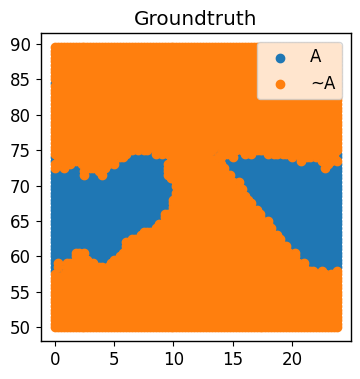

In [26]:
batch_size= 64 # previously 64
nr_samples = 7680 # previously 100

# See https://www.tensorflow.org/tutorials/load_data/numpy
SHUFFLE_BUFFER_SIZE = 7680

half_nr_samples = 6 # no longer used? Only used when randomizing test data?
nr_samples_train = 100 # 5760 # previously 50 E.M. - Why no nr_samples_test ?
# data = np.random.uniform([0,0],[1,1],(half_nr_samples,2))
# data from eflux file (see above): data    = np.array([[0.5,0.5],[0.6,0.6],[0.4,0.4],[0.3,0.3],[0.2,0.2],[0.1,0.1]],  dtype=float)

# Data for A from eflux file on GitHub
print("Data for A:")
print(data) # Added E.M.
# E.M. Changed from [.5,.5] to [.5,1] below:
# labels from eflux file (see above): labels = np.sum(np.square(data-[.5,.5]),axis=1)<.09
# This doesn't work. Error: label needs to be integer or boolean: labels = np.sum(np.square(data-[.5,.5]),axis=1)
print(labels) # Added E.M.

plt.figure(figsize=(4,4))
plt.scatter(data[labels][:,0],data[labels][:,1],label='A')
plt.scatter(data[np.logical_not(labels)][:,0],data[np.logical_not(labels)][:,1],label='~A')

#plt.scatter(data_b[labels_b][:,0],data_b[labels_b][:,1],label='B')
#plt.scatter(data_b[np.logical_not(labels_b)][:,0],data_b[np.logical_not(labels_b)][:,1],label='~B')

plt.title("Groundtruth")
plt.legend()
plt.show()

# Test points for B dataset
print("Data for B:")
# data_b = np.random.uniform([0,0],[1,1],(half_nr_samples,2))
data_b    = np.array([[0.55,0.55],[0.65,0.65],[0.45,0.45],[0.35,0.35],[0.25,0.25],[0.15,0.15]],  dtype=float)
print(data_b) # Added E.M.
# E.M. Changed from [.5,.5] to [.5,1] below:
labels_b = np.sum(np.square(data_b-[.5,.5]),axis=1)<.16
# This doesn't work. Error: label needs to be integer or boolean: labels = np.sum(np.square(data-[.5,.5]),axis=1)
print(labels_b) # Added E.M.

plt.figure(figsize=(4,4))
#plt.scatter(data[labels][:,0],data[labels][:,1],label='A')
#plt.scatter(data[np.logical_not(labels)][:,0],data[np.logical_not(labels)][:,1],label='~A')

plt.scatter(data_b[labels_b][:,0],data_b[labels_b][:,1],label='B')
plt.scatter(data_b[np.logical_not(labels_b)][:,0],data_b[np.logical_not(labels_b)][:,1],label='~B')

plt.title("Groundtruth")
plt.legend()
plt.show()

print("Plotting A and B on same graph")

plt.figure(figsize=(4,4))
plt.scatter(data[labels][:,0],data[labels][:,1],label='A')
plt.scatter(data[np.logical_not(labels)][:,0],data[np.logical_not(labels)][:,1],label='~A')

plt.scatter(data_b[labels_b][:,0],data_b[labels_b][:,1],label='B')
plt.scatter(data_b[np.logical_not(labels_b)][:,0],data_b[np.logical_not(labels_b)][:,1],label='~B')

plt.title("Groundtruth")
plt.legend()
plt.show()

print("Concatendated A and B data (6/23/2024: just using A):")
#data = np.concatenate((data, data_b))
#labels = np.concatenate((labels, labels_b))

print(data)
print(labels)

# Below comment doesn't seem to match program
# 400 examples for training; 100 examples for training
# See https://www.tensorflow.org/tutorials/load_data/numpy
# See https://www.tensorflow.org/guide/data

# Original line:
# ds_train = tf.data.Dataset\
#        .from_tensor_slices((data[:nr_samples_train],labels[:nr_samples_train]))\
#        .batch(batch_size)

# 6/24/2024: Experimenting with training
#     7:15 am: Tried shuffling dataset, but seemed to only get 100 data points. Pulls 100 data points and then shuffles? See below.
# 6/27/2024: Change order of methods .shuffle and .batch.  Missing )?
ds_train = tf.data.Dataset\
        .from_tensor_slices((data[:nr_samples_train],labels[:nr_samples_train]))\
        .batch(batch_size).shuffle(SHUFFLE_BUFFER_SIZE)
#       .shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)


print (ds_train) # Added E. M
ds_test = tf.data.Dataset\
        .from_tensor_slices((data[nr_samples_train:],labels[nr_samples_train:]))\
        .batch(batch_size)
print (ds_test) # Added E. M
plt.figure(figsize=(4,4))
plt.scatter(data[labels][:,0],data[labels][:,1],label='A')
plt.scatter(data[np.logical_not(labels)][:,0],data[np.logical_not(labels)][:,1],label='~A')

#plt.scatter(data_b[labels_b][:,0],data_b[labels_b][:,1],label='B')
#plt.scatter(data_b[np.logical_not(labels_b)][:,0],data_b[np.logical_not(labels_b)][:,1],label='~B')



plt.title("Groundtruth")
plt.legend()
plt.show()


Define the predicate $A$. $A$ has arity 1 (single argument). The dimension of the argument is 2 (since the domain is $[0,1]^2$).

In [27]:
A = ltn.Predicate.MLP([2],hidden_layer_sizes=(16,16))
#A = ltn.Predicate.MLP([2],hidden_layer_sizes=(2,))

Import some operators to write the axioms.

In [28]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=2),semantics="exists")

Now we add some facts to the knowledgebase. We express that for all points in $\mathrm{data\_A}$, $A$ should be true. For all points in $\mathrm{data\_not\_A}$, $A$ is not true.

In [29]:
formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError(p=2))

@tf.function
def axioms(data, labels):
    x_A = ltn.Variable("x_A",data[labels])
    x_not_A = ltn.Variable("x_not_A",data[tf.logical_not(labels)])
   # x_B = ltn.Variable("x_B",data_b[labels_b])
   # x_not_B = ltn.Variable("x_not_B",data_b[tf.logical_not(labels_b)])
    axioms = [
        Forall(x_A, A(x_A)),
        Forall(x_not_A, Not(A(x_not_A)))
    ]
    sat_level = formula_aggregator(axioms).tensor
    return sat_level

Initialize all layers and the static graph.

In [40]:
for _data, _labels in ds_test:
    print("Initial sat level %.5f"%axioms(_data, _labels))
    break


Initial sat level 0.70881


Train on the knowledgebase.

In [41]:
mean_metrics = tf.keras.metrics.Mean()

trainable_variables = A.trainable_variables
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
for epoch in range(2000):
  # 6/27/2024: Added following lines to try and use different training set each epoch
    np.random.shuffle(array_eflux)
    #print(array_eflux)
    array_eflux_mag_coordinates = array_eflux[0:7680,0:2]
    data = array_eflux_mag_coordinates
    #print(data)
    array_eflux_flux = array_eflux[0:7680,2:3]
    #print(array_eflux_flux)
    # Flatten to 1-D array
    array_eflux_flux_flatten = array_eflux_flux.flatten(order = 'C')
    #print(array_eflux_flux_flatten)
    labels = array_eflux_flux_flatten > 1.0
    # labels_b = np.sum(np.square(data_b-[.5,.5]),axis=1)<.16
    #print(labels)
    ds_train = tf.data.Dataset\
        .from_tensor_slices((data[:nr_samples_train],labels[:nr_samples_train]))\
        .batch(batch_size).shuffle(SHUFFLE_BUFFER_SIZE)

    for _data, _labels in ds_train:
        with tf.GradientTape() as tape:
            loss = 1. - axioms(_data, _labels)
        grads = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(grads, trainable_variables))
    if epoch%100 == 0:
        mean_metrics.reset_states()
        for _data, _labels in ds_test:
            mean_metrics(axioms(_data, _labels))
        print("Epoch %d: Sat Level %.3f"%(epoch, mean_metrics.result() ))
mean_metrics.reset_states()
for _data, _labels in ds_test:
    mean_metrics(axioms(_data, _labels))
print("Training finished at Epoch %d with Sat Level %.3f"%(epoch, mean_metrics.result() ))

Epoch 0: Sat Level 0.757
Epoch 100: Sat Level 0.790
Epoch 200: Sat Level 0.784
Epoch 300: Sat Level 0.764
Epoch 400: Sat Level 0.787
Epoch 500: Sat Level 0.790
Epoch 600: Sat Level 0.796
Epoch 700: Sat Level 0.755
Epoch 800: Sat Level 0.794
Epoch 900: Sat Level 0.784
Epoch 1000: Sat Level 0.795
Epoch 1100: Sat Level 0.795
Epoch 1200: Sat Level 0.766
Epoch 1300: Sat Level 0.785
Epoch 1400: Sat Level 0.787
Epoch 1500: Sat Level 0.774
Epoch 1600: Sat Level 0.786
Epoch 1700: Sat Level 0.795
Epoch 1800: Sat Level 0.790
Epoch 1900: Sat Level 0.783
Training finished at Epoch 1999 with Sat Level 0.787


The following queries the database on training data and test data. Vizualisation show the extent of generalization.

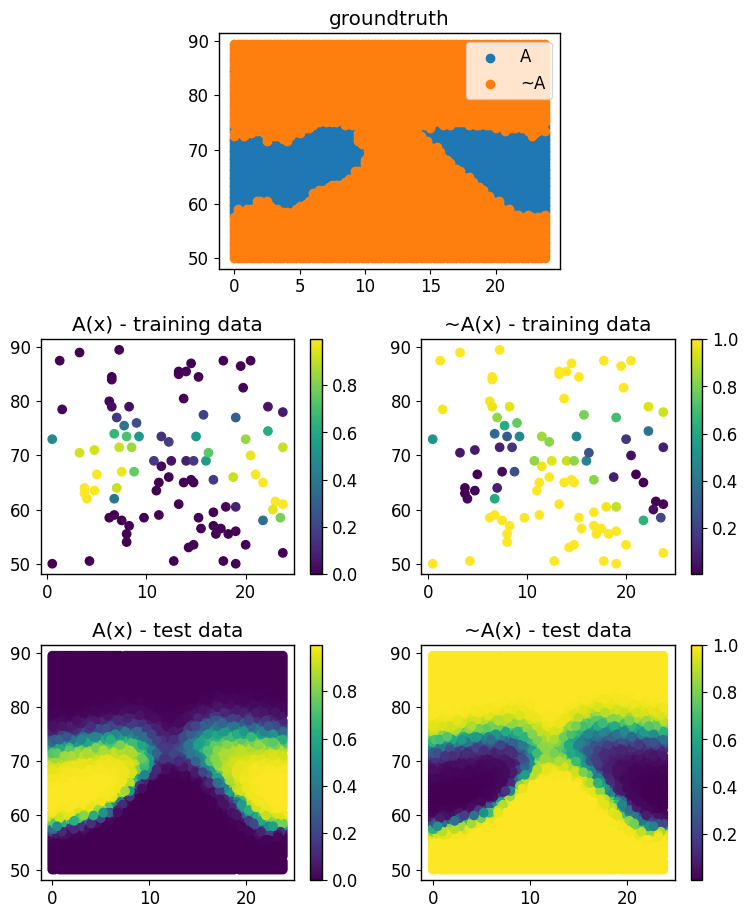

In [42]:
fig = plt.figure(figsize=(9, 11))

plt.subplots_adjust(wspace=0.2,hspace=0.3)
ax = plt.subplot2grid((3,8),(0,2),colspan=4)
ax.set_title("groundtruth")
ax.scatter(data[labels][:,0],data[labels][:,1],label='A')
ax.scatter(data[np.logical_not(labels)][:,0],data[np.logical_not(labels)][:,1],label='~A')
ax.legend()

# Training data
x = ltn.Variable("x",data[:nr_samples_train])
fig.add_subplot(3, 2, 3)
result=A(x)
plt.title("A(x) - training data")
plt.scatter(data[:nr_samples_train,0],data[:nr_samples_train,1],c=result.tensor.numpy().squeeze())
plt.colorbar()

fig.add_subplot(3, 2, 4)
result=Not(A(x))
plt.title("~A(x) - training data")
plt.scatter(data[:nr_samples_train,0],data[:nr_samples_train,1],c=result.tensor.numpy().squeeze())
plt.colorbar()

# Test data
x = ltn.Variable("x",data[nr_samples_train:])
fig.add_subplot(3, 2, 5)

result=A(x)
plt.title("A(x) - test data")
plt.scatter(data[nr_samples_train:,0],data[nr_samples_train:,1],c=result.tensor.numpy().squeeze())
plt.colorbar()

fig.add_subplot(3, 2, 6)
result=Not(A(x))
plt.title("~A(x) - test data")
plt.scatter(data[nr_samples_train:,0],data[nr_samples_train:,1],c=result.tensor.numpy().squeeze())
plt.colorbar()
plt.savefig("ex_binary_testing.pdf")
plt.show()